In [1]:
# Step 1: Install required libraries
!pip install transformers datasets torch scikit-learn streamlit gradio
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.0
    Uninstalling accelerate-1.10.0:
      Successfully uninstalled accelerate-1.10.0


In [2]:
!pip install transformers datasets torch scikit-learn streamlit gradio

In [3]:
!pip uninstall transformers -y
!pip install transformers

Found existing installation: transformers 4.55.2
Uninstalling transformers-4.55.2:
  Successfully uninstalled transformers-4.55.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 59.4 MB/s eta 0:00:00


In [6]:
# Step 2: Import all necessary libraries
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW from torch.optim
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import random

# Set random seeds for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

print("All libraries imported successfully!")

All libraries imported successfully!


In [7]:
# Step 3: Load and explore the AG News dataset
print("Loading AG News dataset...")
dataset = load_dataset('ag_news')

print(f"Dataset structure: {dataset}")
print(f"Training set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

# Check a few samples
print("\nSample training examples:")
for i in range(3):
    print(f"Text: {dataset['train'][i]['text']}")
    print(f"Label: {dataset['train'][i]['label']}")
    print("-" * 80)

# Check class distribution
train_labels = [example['label'] for example in dataset['train']]
test_labels = [example['label'] for example in dataset['test']]

print(f"\nTraining set class distribution:")
for i in range(4):
    print(f"Class {i}: {train_labels.count(i)} samples")

print(f"\nTest set class distribution:")
for i in range(4):
    print(f"Class {i}: {test_labels.count(i)} samples")

Loading AG News dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
Training set size: 120000
Test set size: 7600

Sample training examples:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: 2
--------------------------------------------------------------------------------
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Label: 2
--------------------------------------------------------------------------------
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the ec

In [8]:
# Step 4: Initialize tokenizer and preprocess data
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to tokenize the dataset
def tokenize_function(examples):
    # Tokenize the texts
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print("Tokenizing dataset...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename the label column to labels (as expected by BERT)
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')

# Set the format to PyTorch tensors
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Check the tokenized dataset structure
print("Sample tokenized data:")
print(tokenized_datasets['train'][0])

Initializing BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Sample tokenized data:
{'labels': tensor(2), 'input_ids': tensor([  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
         1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
         2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
         1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [9]:
# Step 5: Prepare DataLoaders
batch_size = 16

train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=batch_size
)

# Check a batch
batch = next(iter(train_dataloader))
print(f"Input IDs shape: {batch['input_ids'].shape}")
print(f"Attention mask shape: {batch['attention_mask'].shape}")
print(f"Labels shape: {batch['labels'].shape}")

Input IDs shape: torch.Size([16, 128])
Attention mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


In [11]:
# Step 6: Initialize the BERT model
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the BERT model for sequence classification
print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4,  # AG News has 4 classes
    output_attentions=False,
    output_hidden_states=False
)

# Move model to the appropriate device
model.to(device)
print("Model loaded successfully!")

Using device: cuda
Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


In [12]:
# Step 7: Set up training parameters
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Number of training epochs
epochs = 3

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Training for {epochs} epochs")
print(f"Total training steps: {total_steps}")

Training for 3 epochs
Total training steps: 22500


In [13]:
# Step 8: Training utilities
# Helper function to format time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round(elapsed))
    return str(time.strftime('%H:%M:%S', time.gmtime(elapsed_rounded)))

# Import datetime for the format_time function
import datetime
import time

In [14]:
# Step 9: Training loop
print("Starting training...")
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        # Unpack this training batch from our dataloader
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Clear any previously calculated gradients
        model.zero_grad()

        # Perform a forward pass
        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Record all statistics from this epoch
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Training Time': training_time,
    })

print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")

Starting training...
======== Epoch 1 / 3 ========
Training...



Training:   1%|          | 40/7500 [00:13<39:13,  3.17it/s]

  Batch 40  of  7500.    Elapsed: 00:00:13.



Training:   1%|          | 80/7500 [00:26<39:29,  3.13it/s]

  Batch 80  of  7500.    Elapsed: 00:00:26.



Training:   2%|▏         | 120/7500 [00:39<40:27,  3.04it/s]

  Batch 120  of  7500.    Elapsed: 00:00:39.



Training:   2%|▏         | 160/7500 [00:52<39:57,  3.06it/s]

  Batch 160  of  7500.    Elapsed: 00:00:52.



Training:   3%|▎         | 200/7500 [01:05<40:13,  3.02it/s]

  Batch 200  of  7500.    Elapsed: 00:01:05.



Training:   3%|▎         | 240/7500 [01:18<40:31,  2.99it/s]

  Batch 240  of  7500.    Elapsed: 00:01:19.



Training:   4%|▎         | 280/7500 [01:32<40:56,  2.94it/s]

  Batch 280  of  7500.    Elapsed: 00:01:32.



Training:   4%|▍         | 320/7500 [01:46<41:27,  2.89it/s]

  Batch 320  of  7500.    Elapsed: 00:01:46.



Training:   5%|▍         | 360/7500 [02:00<41:58,  2.84it/s]

  Batch 360  of  7500.    Elapsed: 00:02:00.



Training:   5%|▌         | 400/7500 [02:14<41:53,  2.82it/s]

  Batch 400  of  7500.    Elapsed: 00:02:14.



Training:   6%|▌         | 440/7500 [02:28<40:32,  2.90it/s]

  Batch 440  of  7500.    Elapsed: 00:02:28.



Training:   6%|▋         | 480/7500 [02:41<40:25,  2.89it/s]

  Batch 480  of  7500.    Elapsed: 00:02:42.



Training:   7%|▋         | 520/7500 [02:55<39:46,  2.92it/s]

  Batch 520  of  7500.    Elapsed: 00:02:56.



Training:   7%|▋         | 560/7500 [03:09<39:49,  2.90it/s]

  Batch 560  of  7500.    Elapsed: 00:03:09.



Training:   8%|▊         | 600/7500 [03:23<40:01,  2.87it/s]

  Batch 600  of  7500.    Elapsed: 00:03:23.



Training:   9%|▊         | 640/7500 [03:37<39:53,  2.87it/s]

  Batch 640  of  7500.    Elapsed: 00:03:37.



Training:   9%|▉         | 680/7500 [03:51<39:23,  2.89it/s]

  Batch 680  of  7500.    Elapsed: 00:03:51.



Training:  10%|▉         | 720/7500 [04:04<39:01,  2.89it/s]

  Batch 720  of  7500.    Elapsed: 00:04:05.



Training:  10%|█         | 760/7500 [04:18<38:48,  2.89it/s]

  Batch 760  of  7500.    Elapsed: 00:04:19.



Training:  11%|█         | 800/7500 [04:32<38:28,  2.90it/s]

  Batch 800  of  7500.    Elapsed: 00:04:33.



Training:  11%|█         | 840/7500 [04:46<38:10,  2.91it/s]

  Batch 840  of  7500.    Elapsed: 00:04:46.



Training:  12%|█▏        | 880/7500 [05:00<38:08,  2.89it/s]

  Batch 880  of  7500.    Elapsed: 00:05:00.



Training:  12%|█▏        | 920/7500 [05:14<37:47,  2.90it/s]

  Batch 920  of  7500.    Elapsed: 00:05:14.



Training:  13%|█▎        | 960/7500 [05:27<37:47,  2.88it/s]

  Batch 960  of  7500.    Elapsed: 00:05:28.



Training:  13%|█▎        | 1000/7500 [05:41<37:44,  2.87it/s]

  Batch 1000  of  7500.    Elapsed: 00:05:42.



Training:  14%|█▍        | 1040/7500 [05:55<37:35,  2.86it/s]

  Batch 1040  of  7500.    Elapsed: 00:05:56.



Training:  14%|█▍        | 1080/7500 [06:09<36:56,  2.90it/s]

  Batch 1080  of  7500.    Elapsed: 00:06:10.



Training:  15%|█▍        | 1120/7500 [06:23<36:49,  2.89it/s]

  Batch 1120  of  7500.    Elapsed: 00:06:23.



Training:  15%|█▌        | 1160/7500 [06:37<36:35,  2.89it/s]

  Batch 1160  of  7500.    Elapsed: 00:06:37.



Training:  16%|█▌        | 1200/7500 [06:51<36:18,  2.89it/s]

  Batch 1200  of  7500.    Elapsed: 00:06:51.



Training:  17%|█▋        | 1240/7500 [07:04<36:11,  2.88it/s]

  Batch 1240  of  7500.    Elapsed: 00:07:05.



Training:  17%|█▋        | 1280/7500 [07:18<36:13,  2.86it/s]

  Batch 1280  of  7500.    Elapsed: 00:07:19.



Training:  18%|█▊        | 1320/7500 [07:32<35:28,  2.90it/s]

  Batch 1320  of  7500.    Elapsed: 00:07:33.



Training:  18%|█▊        | 1360/7500 [07:46<35:16,  2.90it/s]

  Batch 1360  of  7500.    Elapsed: 00:07:46.



Training:  19%|█▊        | 1400/7500 [08:00<35:11,  2.89it/s]

  Batch 1400  of  7500.    Elapsed: 00:08:00.



Training:  19%|█▉        | 1440/7500 [08:14<34:49,  2.90it/s]

  Batch 1440  of  7500.    Elapsed: 00:08:14.



Training:  20%|█▉        | 1480/7500 [08:27<34:32,  2.90it/s]

  Batch 1480  of  7500.    Elapsed: 00:08:28.



Training:  20%|██        | 1520/7500 [08:41<34:24,  2.90it/s]

  Batch 1520  of  7500.    Elapsed: 00:08:42.



Training:  21%|██        | 1560/7500 [08:55<34:20,  2.88it/s]

  Batch 1560  of  7500.    Elapsed: 00:08:56.



Training:  21%|██▏       | 1600/7500 [09:09<33:58,  2.89it/s]

  Batch 1600  of  7500.    Elapsed: 00:09:10.



Training:  22%|██▏       | 1640/7500 [09:23<33:45,  2.89it/s]

  Batch 1640  of  7500.    Elapsed: 00:09:23.



Training:  22%|██▏       | 1680/7500 [09:37<33:29,  2.90it/s]

  Batch 1680  of  7500.    Elapsed: 00:09:37.



Training:  23%|██▎       | 1720/7500 [09:51<33:24,  2.88it/s]

  Batch 1720  of  7500.    Elapsed: 00:09:51.



Training:  23%|██▎       | 1760/7500 [10:04<33:00,  2.90it/s]

  Batch 1760  of  7500.    Elapsed: 00:10:05.



Training:  24%|██▍       | 1800/7500 [10:18<32:49,  2.89it/s]

  Batch 1800  of  7500.    Elapsed: 00:10:19.



Training:  25%|██▍       | 1840/7500 [10:32<32:40,  2.89it/s]

  Batch 1840  of  7500.    Elapsed: 00:10:33.



Training:  25%|██▌       | 1880/7500 [10:46<32:14,  2.91it/s]

  Batch 1880  of  7500.    Elapsed: 00:10:46.



Training:  26%|██▌       | 1920/7500 [11:00<32:06,  2.90it/s]

  Batch 1920  of  7500.    Elapsed: 00:11:00.



Training:  26%|██▌       | 1960/7500 [11:14<32:01,  2.88it/s]

  Batch 1960  of  7500.    Elapsed: 00:11:14.



Training:  27%|██▋       | 2000/7500 [11:27<31:37,  2.90it/s]

  Batch 2000  of  7500.    Elapsed: 00:11:28.



Training:  27%|██▋       | 2040/7500 [11:41<31:07,  2.92it/s]

  Batch 2040  of  7500.    Elapsed: 00:11:42.



Training:  28%|██▊       | 2080/7500 [11:55<31:18,  2.89it/s]

  Batch 2080  of  7500.    Elapsed: 00:11:56.



Training:  28%|██▊       | 2120/7500 [12:09<31:01,  2.89it/s]

  Batch 2120  of  7500.    Elapsed: 00:12:09.



Training:  29%|██▉       | 2160/7500 [12:23<30:38,  2.90it/s]

  Batch 2160  of  7500.    Elapsed: 00:12:23.



Training:  29%|██▉       | 2200/7500 [12:37<30:29,  2.90it/s]

  Batch 2200  of  7500.    Elapsed: 00:12:37.



Training:  30%|██▉       | 2240/7500 [12:50<30:22,  2.89it/s]

  Batch 2240  of  7500.    Elapsed: 00:12:51.



Training:  30%|███       | 2280/7500 [13:04<30:02,  2.90it/s]

  Batch 2280  of  7500.    Elapsed: 00:13:05.



Training:  31%|███       | 2320/7500 [13:18<29:47,  2.90it/s]

  Batch 2320  of  7500.    Elapsed: 00:13:19.



Training:  31%|███▏      | 2360/7500 [13:32<29:40,  2.89it/s]

  Batch 2360  of  7500.    Elapsed: 00:13:32.



Training:  32%|███▏      | 2400/7500 [13:46<29:25,  2.89it/s]

  Batch 2400  of  7500.    Elapsed: 00:13:46.



Training:  33%|███▎      | 2440/7500 [14:00<29:06,  2.90it/s]

  Batch 2440  of  7500.    Elapsed: 00:14:00.



Training:  33%|███▎      | 2480/7500 [14:13<28:52,  2.90it/s]

  Batch 2480  of  7500.    Elapsed: 00:14:14.



Training:  34%|███▎      | 2520/7500 [14:27<28:38,  2.90it/s]

  Batch 2520  of  7500.    Elapsed: 00:14:28.



Training:  34%|███▍      | 2560/7500 [14:41<28:23,  2.90it/s]

  Batch 2560  of  7500.    Elapsed: 00:14:42.



Training:  35%|███▍      | 2600/7500 [14:55<28:14,  2.89it/s]

  Batch 2600  of  7500.    Elapsed: 00:14:55.



Training:  35%|███▌      | 2640/7500 [15:09<28:03,  2.89it/s]

  Batch 2640  of  7500.    Elapsed: 00:15:09.



Training:  36%|███▌      | 2680/7500 [15:23<27:50,  2.88it/s]

  Batch 2680  of  7500.    Elapsed: 00:15:23.



Training:  36%|███▋      | 2720/7500 [15:36<27:25,  2.91it/s]

  Batch 2720  of  7500.    Elapsed: 00:15:37.



Training:  37%|███▋      | 2760/7500 [15:50<27:32,  2.87it/s]

  Batch 2760  of  7500.    Elapsed: 00:15:51.



Training:  37%|███▋      | 2800/7500 [16:04<27:12,  2.88it/s]

  Batch 2800  of  7500.    Elapsed: 00:16:05.



Training:  38%|███▊      | 2840/7500 [16:18<26:54,  2.89it/s]

  Batch 2840  of  7500.    Elapsed: 00:16:19.



Training:  38%|███▊      | 2880/7500 [16:32<26:34,  2.90it/s]

  Batch 2880  of  7500.    Elapsed: 00:16:32.



Training:  39%|███▉      | 2920/7500 [16:46<26:22,  2.89it/s]

  Batch 2920  of  7500.    Elapsed: 00:16:46.



Training:  39%|███▉      | 2960/7500 [17:00<26:17,  2.88it/s]

  Batch 2960  of  7500.    Elapsed: 00:17:00.



Training:  40%|████      | 3000/7500 [17:13<25:41,  2.92it/s]

  Batch 3000  of  7500.    Elapsed: 00:17:14.



Training:  41%|████      | 3040/7500 [17:27<25:40,  2.90it/s]

  Batch 3040  of  7500.    Elapsed: 00:17:28.



Training:  41%|████      | 3080/7500 [17:41<25:24,  2.90it/s]

  Batch 3080  of  7500.    Elapsed: 00:17:42.



Training:  42%|████▏     | 3120/7500 [17:55<25:11,  2.90it/s]

  Batch 3120  of  7500.    Elapsed: 00:17:55.



Training:  42%|████▏     | 3160/7500 [18:09<24:59,  2.89it/s]

  Batch 3160  of  7500.    Elapsed: 00:18:09.



Training:  43%|████▎     | 3200/7500 [18:23<24:48,  2.89it/s]

  Batch 3200  of  7500.    Elapsed: 00:18:23.



Training:  43%|████▎     | 3240/7500 [18:36<24:38,  2.88it/s]

  Batch 3240  of  7500.    Elapsed: 00:18:37.



Training:  44%|████▎     | 3280/7500 [18:50<24:25,  2.88it/s]

  Batch 3280  of  7500.    Elapsed: 00:18:51.



Training:  44%|████▍     | 3320/7500 [19:04<24:04,  2.89it/s]

  Batch 3320  of  7500.    Elapsed: 00:19:05.



Training:  45%|████▍     | 3360/7500 [19:18<23:55,  2.88it/s]

  Batch 3360  of  7500.    Elapsed: 00:19:18.



Training:  45%|████▌     | 3400/7500 [19:32<23:40,  2.89it/s]

  Batch 3400  of  7500.    Elapsed: 00:19:32.



Training:  46%|████▌     | 3440/7500 [19:46<23:20,  2.90it/s]

  Batch 3440  of  7500.    Elapsed: 00:19:46.



Training:  46%|████▋     | 3480/7500 [19:59<23:12,  2.89it/s]

  Batch 3480  of  7500.    Elapsed: 00:20:00.



Training:  47%|████▋     | 3520/7500 [20:13<23:13,  2.86it/s]

  Batch 3520  of  7500.    Elapsed: 00:20:14.



Training:  47%|████▋     | 3560/7500 [20:27<22:50,  2.88it/s]

  Batch 3560  of  7500.    Elapsed: 00:20:28.



Training:  48%|████▊     | 3600/7500 [20:41<22:27,  2.89it/s]

  Batch 3600  of  7500.    Elapsed: 00:20:41.



Training:  49%|████▊     | 3640/7500 [20:55<22:15,  2.89it/s]

  Batch 3640  of  7500.    Elapsed: 00:20:55.



Training:  49%|████▉     | 3680/7500 [21:09<22:00,  2.89it/s]

  Batch 3680  of  7500.    Elapsed: 00:21:09.



Training:  50%|████▉     | 3720/7500 [21:23<21:47,  2.89it/s]

  Batch 3720  of  7500.    Elapsed: 00:21:23.



Training:  50%|█████     | 3760/7500 [21:36<21:30,  2.90it/s]

  Batch 3760  of  7500.    Elapsed: 00:21:37.



Training:  51%|█████     | 3800/7500 [21:50<21:17,  2.90it/s]

  Batch 3800  of  7500.    Elapsed: 00:21:51.



Training:  51%|█████     | 3840/7500 [22:04<21:13,  2.87it/s]

  Batch 3840  of  7500.    Elapsed: 00:22:05.



Training:  52%|█████▏    | 3880/7500 [22:18<20:47,  2.90it/s]

  Batch 3880  of  7500.    Elapsed: 00:22:18.



Training:  52%|█████▏    | 3920/7500 [22:32<20:35,  2.90it/s]

  Batch 3920  of  7500.    Elapsed: 00:22:32.



Training:  53%|█████▎    | 3960/7500 [22:46<20:38,  2.86it/s]

  Batch 3960  of  7500.    Elapsed: 00:22:46.



Training:  53%|█████▎    | 4000/7500 [22:59<20:12,  2.89it/s]

  Batch 4000  of  7500.    Elapsed: 00:23:00.



Training:  54%|█████▍    | 4040/7500 [23:13<19:55,  2.89it/s]

  Batch 4040  of  7500.    Elapsed: 00:23:14.



Training:  54%|█████▍    | 4080/7500 [23:27<19:41,  2.90it/s]

  Batch 4080  of  7500.    Elapsed: 00:23:28.



Training:  55%|█████▍    | 4120/7500 [23:41<19:32,  2.88it/s]

  Batch 4120  of  7500.    Elapsed: 00:23:41.



Training:  55%|█████▌    | 4160/7500 [23:55<19:27,  2.86it/s]

  Batch 4160  of  7500.    Elapsed: 00:23:55.



Training:  56%|█████▌    | 4200/7500 [24:09<19:01,  2.89it/s]

  Batch 4200  of  7500.    Elapsed: 00:24:09.



Training:  57%|█████▋    | 4240/7500 [24:22<18:41,  2.91it/s]

  Batch 4240  of  7500.    Elapsed: 00:24:23.



Training:  57%|█████▋    | 4280/7500 [24:36<18:31,  2.90it/s]

  Batch 4280  of  7500.    Elapsed: 00:24:37.



Training:  58%|█████▊    | 4320/7500 [24:50<18:19,  2.89it/s]

  Batch 4320  of  7500.    Elapsed: 00:24:51.



Training:  58%|█████▊    | 4360/7500 [25:04<18:03,  2.90it/s]

  Batch 4360  of  7500.    Elapsed: 00:25:05.



Training:  59%|█████▊    | 4400/7500 [25:18<17:54,  2.89it/s]

  Batch 4400  of  7500.    Elapsed: 00:25:18.



Training:  59%|█████▉    | 4440/7500 [25:32<17:37,  2.89it/s]

  Batch 4440  of  7500.    Elapsed: 00:25:32.



Training:  60%|█████▉    | 4480/7500 [25:46<17:19,  2.90it/s]

  Batch 4480  of  7500.    Elapsed: 00:25:46.



Training:  60%|██████    | 4520/7500 [25:59<17:06,  2.90it/s]

  Batch 4520  of  7500.    Elapsed: 00:26:00.



Training:  61%|██████    | 4560/7500 [26:13<16:52,  2.90it/s]

  Batch 4560  of  7500.    Elapsed: 00:26:14.



Training:  61%|██████▏   | 4600/7500 [26:27<16:44,  2.89it/s]

  Batch 4600  of  7500.    Elapsed: 00:26:27.



Training:  62%|██████▏   | 4640/7500 [26:41<16:30,  2.89it/s]

  Batch 4640  of  7500.    Elapsed: 00:26:41.



Training:  62%|██████▏   | 4680/7500 [26:55<16:10,  2.90it/s]

  Batch 4680  of  7500.    Elapsed: 00:26:55.



Training:  63%|██████▎   | 4720/7500 [27:08<15:59,  2.90it/s]

  Batch 4720  of  7500.    Elapsed: 00:27:09.



Training:  63%|██████▎   | 4760/7500 [27:22<15:53,  2.87it/s]

  Batch 4760  of  7500.    Elapsed: 00:27:23.



Training:  64%|██████▍   | 4800/7500 [27:36<15:29,  2.91it/s]

  Batch 4800  of  7500.    Elapsed: 00:27:37.



Training:  65%|██████▍   | 4840/7500 [27:50<15:20,  2.89it/s]

  Batch 4840  of  7500.    Elapsed: 00:27:51.



Training:  65%|██████▌   | 4880/7500 [28:04<15:10,  2.88it/s]

  Batch 4880  of  7500.    Elapsed: 00:28:04.



Training:  66%|██████▌   | 4920/7500 [28:18<14:52,  2.89it/s]

  Batch 4920  of  7500.    Elapsed: 00:28:18.



Training:  66%|██████▌   | 4960/7500 [28:32<14:43,  2.88it/s]

  Batch 4960  of  7500.    Elapsed: 00:28:32.



Training:  67%|██████▋   | 5000/7500 [28:45<14:22,  2.90it/s]

  Batch 5000  of  7500.    Elapsed: 00:28:46.



Training:  67%|██████▋   | 5040/7500 [28:59<14:13,  2.88it/s]

  Batch 5040  of  7500.    Elapsed: 00:29:00.



Training:  68%|██████▊   | 5080/7500 [29:13<13:52,  2.91it/s]

  Batch 5080  of  7500.    Elapsed: 00:29:14.



Training:  68%|██████▊   | 5120/7500 [29:27<13:45,  2.88it/s]

  Batch 5120  of  7500.    Elapsed: 00:29:27.



Training:  69%|██████▉   | 5160/7500 [29:41<13:31,  2.88it/s]

  Batch 5160  of  7500.    Elapsed: 00:29:41.



Training:  69%|██████▉   | 5200/7500 [29:55<13:15,  2.89it/s]

  Batch 5200  of  7500.    Elapsed: 00:29:55.



Training:  70%|██████▉   | 5240/7500 [30:08<13:01,  2.89it/s]

  Batch 5240  of  7500.    Elapsed: 00:30:09.



Training:  70%|███████   | 5280/7500 [30:22<12:50,  2.88it/s]

  Batch 5280  of  7500.    Elapsed: 00:30:23.



Training:  71%|███████   | 5320/7500 [30:36<12:38,  2.87it/s]

  Batch 5320  of  7500.    Elapsed: 00:30:37.



Training:  71%|███████▏  | 5360/7500 [30:50<12:14,  2.92it/s]

  Batch 5360  of  7500.    Elapsed: 00:30:51.



Training:  72%|███████▏  | 5400/7500 [31:04<11:58,  2.92it/s]

  Batch 5400  of  7500.    Elapsed: 00:31:04.



Training:  73%|███████▎  | 5440/7500 [31:18<11:52,  2.89it/s]

  Batch 5440  of  7500.    Elapsed: 00:31:18.



Training:  73%|███████▎  | 5480/7500 [31:32<11:38,  2.89it/s]

  Batch 5480  of  7500.    Elapsed: 00:31:32.



Training:  74%|███████▎  | 5520/7500 [31:45<11:27,  2.88it/s]

  Batch 5520  of  7500.    Elapsed: 00:31:46.



Training:  74%|███████▍  | 5560/7500 [31:59<11:12,  2.88it/s]

  Batch 5560  of  7500.    Elapsed: 00:32:00.



Training:  75%|███████▍  | 5600/7500 [32:13<10:56,  2.89it/s]

  Batch 5600  of  7500.    Elapsed: 00:32:14.



Training:  75%|███████▌  | 5640/7500 [32:27<10:49,  2.86it/s]

  Batch 5640  of  7500.    Elapsed: 00:32:28.



Training:  76%|███████▌  | 5680/7500 [32:41<10:32,  2.88it/s]

  Batch 5680  of  7500.    Elapsed: 00:32:41.



Training:  76%|███████▋  | 5720/7500 [32:55<10:16,  2.88it/s]

  Batch 5720  of  7500.    Elapsed: 00:32:55.



Training:  77%|███████▋  | 5760/7500 [33:09<09:59,  2.90it/s]

  Batch 5760  of  7500.    Elapsed: 00:33:09.



Training:  77%|███████▋  | 5800/7500 [33:22<09:48,  2.89it/s]

  Batch 5800  of  7500.    Elapsed: 00:33:23.



Training:  78%|███████▊  | 5840/7500 [33:36<09:34,  2.89it/s]

  Batch 5840  of  7500.    Elapsed: 00:33:37.



Training:  78%|███████▊  | 5880/7500 [33:50<09:18,  2.90it/s]

  Batch 5880  of  7500.    Elapsed: 00:33:51.



Training:  79%|███████▉  | 5920/7500 [34:04<09:05,  2.89it/s]

  Batch 5920  of  7500.    Elapsed: 00:34:04.



Training:  79%|███████▉  | 5960/7500 [34:18<08:53,  2.89it/s]

  Batch 5960  of  7500.    Elapsed: 00:34:18.



Training:  80%|████████  | 6000/7500 [34:32<08:37,  2.90it/s]

  Batch 6000  of  7500.    Elapsed: 00:34:32.



Training:  81%|████████  | 6040/7500 [34:46<08:25,  2.89it/s]

  Batch 6040  of  7500.    Elapsed: 00:34:46.



Training:  81%|████████  | 6080/7500 [34:59<08:10,  2.89it/s]

  Batch 6080  of  7500.    Elapsed: 00:35:00.



Training:  82%|████████▏ | 6120/7500 [35:13<07:56,  2.90it/s]

  Batch 6120  of  7500.    Elapsed: 00:35:14.



Training:  82%|████████▏ | 6160/7500 [35:27<07:42,  2.90it/s]

  Batch 6160  of  7500.    Elapsed: 00:35:28.



Training:  83%|████████▎ | 6200/7500 [35:41<07:29,  2.89it/s]

  Batch 6200  of  7500.    Elapsed: 00:35:41.



Training:  83%|████████▎ | 6240/7500 [35:55<07:18,  2.87it/s]

  Batch 6240  of  7500.    Elapsed: 00:35:55.



Training:  84%|████████▎ | 6280/7500 [36:09<07:02,  2.89it/s]

  Batch 6280  of  7500.    Elapsed: 00:36:09.



Training:  84%|████████▍ | 6320/7500 [36:22<06:46,  2.90it/s]

  Batch 6320  of  7500.    Elapsed: 00:36:23.



Training:  85%|████████▍ | 6360/7500 [36:36<06:33,  2.89it/s]

  Batch 6360  of  7500.    Elapsed: 00:36:37.



Training:  85%|████████▌ | 6400/7500 [36:50<06:19,  2.89it/s]

  Batch 6400  of  7500.    Elapsed: 00:36:51.



Training:  86%|████████▌ | 6440/7500 [37:04<06:06,  2.89it/s]

  Batch 6440  of  7500.    Elapsed: 00:37:04.



Training:  86%|████████▋ | 6480/7500 [37:18<05:53,  2.88it/s]

  Batch 6480  of  7500.    Elapsed: 00:37:18.



Training:  87%|████████▋ | 6520/7500 [37:32<05:38,  2.89it/s]

  Batch 6520  of  7500.    Elapsed: 00:37:32.



Training:  87%|████████▋ | 6560/7500 [37:45<05:24,  2.89it/s]

  Batch 6560  of  7500.    Elapsed: 00:37:46.



Training:  88%|████████▊ | 6600/7500 [37:59<05:09,  2.91it/s]

  Batch 6600  of  7500.    Elapsed: 00:38:00.



Training:  89%|████████▊ | 6640/7500 [38:13<04:56,  2.90it/s]

  Batch 6640  of  7500.    Elapsed: 00:38:14.



Training:  89%|████████▉ | 6680/7500 [38:27<04:44,  2.89it/s]

  Batch 6680  of  7500.    Elapsed: 00:38:27.



Training:  90%|████████▉ | 6720/7500 [38:41<04:29,  2.89it/s]

  Batch 6720  of  7500.    Elapsed: 00:38:41.



Training:  90%|█████████ | 6760/7500 [38:55<04:15,  2.90it/s]

  Batch 6760  of  7500.    Elapsed: 00:38:55.



Training:  91%|█████████ | 6800/7500 [39:08<04:02,  2.88it/s]

  Batch 6800  of  7500.    Elapsed: 00:39:09.



Training:  91%|█████████ | 6840/7500 [39:22<03:47,  2.90it/s]

  Batch 6840  of  7500.    Elapsed: 00:39:23.



Training:  92%|█████████▏| 6880/7500 [39:36<03:35,  2.88it/s]

  Batch 6880  of  7500.    Elapsed: 00:39:37.



Training:  92%|█████████▏| 6920/7500 [39:50<03:19,  2.90it/s]

  Batch 6920  of  7500.    Elapsed: 00:39:50.



Training:  93%|█████████▎| 6960/7500 [40:04<03:06,  2.90it/s]

  Batch 6960  of  7500.    Elapsed: 00:40:04.



Training:  93%|█████████▎| 7000/7500 [40:18<02:52,  2.89it/s]

  Batch 7000  of  7500.    Elapsed: 00:40:18.



Training:  94%|█████████▍| 7040/7500 [40:31<02:39,  2.89it/s]

  Batch 7040  of  7500.    Elapsed: 00:40:32.



Training:  94%|█████████▍| 7080/7500 [40:45<02:25,  2.88it/s]

  Batch 7080  of  7500.    Elapsed: 00:40:46.



Training:  95%|█████████▍| 7120/7500 [40:59<02:11,  2.89it/s]

  Batch 7120  of  7500.    Elapsed: 00:41:00.



Training:  95%|█████████▌| 7160/7500 [41:13<01:58,  2.87it/s]

  Batch 7160  of  7500.    Elapsed: 00:41:14.



Training:  96%|█████████▌| 7200/7500 [41:27<01:44,  2.87it/s]

  Batch 7200  of  7500.    Elapsed: 00:41:27.



Training:  97%|█████████▋| 7240/7500 [41:41<01:29,  2.90it/s]

  Batch 7240  of  7500.    Elapsed: 00:41:41.



Training:  97%|█████████▋| 7280/7500 [41:55<01:16,  2.89it/s]

  Batch 7280  of  7500.    Elapsed: 00:41:55.



Training:  98%|█████████▊| 7320/7500 [42:08<01:02,  2.90it/s]

  Batch 7320  of  7500.    Elapsed: 00:42:09.



Training:  98%|█████████▊| 7360/7500 [42:22<00:48,  2.88it/s]

  Batch 7360  of  7500.    Elapsed: 00:42:23.



Training:  99%|█████████▊| 7400/7500 [42:36<00:34,  2.88it/s]

  Batch 7400  of  7500.    Elapsed: 00:42:37.



Training:  99%|█████████▉| 7440/7500 [42:50<00:20,  2.88it/s]

  Batch 7440  of  7500.    Elapsed: 00:42:51.



Training: 100%|█████████▉| 7480/7500 [43:04<00:06,  2.87it/s]

  Batch 7480  of  7500.    Elapsed: 00:43:04.



Training: 100%|██████████| 7500/7500 [43:11<00:00,  2.89it/s]


  Average training loss: 0.23
  Training epoch took: 00:43:11
======== Epoch 2 / 3 ========
Training...



Training:   1%|          | 40/7500 [00:13<43:04,  2.89it/s]

  Batch 40  of  7500.    Elapsed: 00:00:14.



Training:   1%|          | 80/7500 [00:27<42:53,  2.88it/s]

  Batch 80  of  7500.    Elapsed: 00:00:28.



Training:   2%|▏         | 120/7500 [00:41<43:06,  2.85it/s]

  Batch 120  of  7500.    Elapsed: 00:00:42.



Training:   2%|▏         | 160/7500 [00:55<42:34,  2.87it/s]

  Batch 160  of  7500.    Elapsed: 00:00:55.



Training:   3%|▎         | 200/7500 [01:09<41:57,  2.90it/s]

  Batch 200  of  7500.    Elapsed: 00:01:09.



Training:   3%|▎         | 240/7500 [01:23<41:53,  2.89it/s]

  Batch 240  of  7500.    Elapsed: 00:01:23.



Training:   4%|▎         | 280/7500 [01:36<41:34,  2.89it/s]

  Batch 280  of  7500.    Elapsed: 00:01:37.



Training:   4%|▍         | 320/7500 [01:50<41:19,  2.90it/s]

  Batch 320  of  7500.    Elapsed: 00:01:51.



Training:   5%|▍         | 360/7500 [02:04<41:18,  2.88it/s]

  Batch 360  of  7500.    Elapsed: 00:02:05.



Training:   5%|▌         | 400/7500 [02:18<40:58,  2.89it/s]

  Batch 400  of  7500.    Elapsed: 00:02:18.



Training:   6%|▌         | 440/7500 [02:32<40:53,  2.88it/s]

  Batch 440  of  7500.    Elapsed: 00:02:32.



Training:   6%|▋         | 480/7500 [02:46<40:34,  2.88it/s]

  Batch 480  of  7500.    Elapsed: 00:02:46.



Training:   7%|▋         | 520/7500 [02:59<40:00,  2.91it/s]

  Batch 520  of  7500.    Elapsed: 00:03:00.



Training:   7%|▋         | 560/7500 [03:13<39:56,  2.90it/s]

  Batch 560  of  7500.    Elapsed: 00:03:14.



Training:   8%|▊         | 600/7500 [03:27<39:41,  2.90it/s]

  Batch 600  of  7500.    Elapsed: 00:03:28.



Training:   9%|▊         | 640/7500 [03:41<39:25,  2.90it/s]

  Batch 640  of  7500.    Elapsed: 00:03:41.



Training:   9%|▉         | 680/7500 [03:55<39:26,  2.88it/s]

  Batch 680  of  7500.    Elapsed: 00:03:55.



Training:  10%|▉         | 720/7500 [04:09<39:01,  2.90it/s]

  Batch 720  of  7500.    Elapsed: 00:04:09.



Training:  10%|█         | 760/7500 [04:23<39:04,  2.87it/s]

  Batch 760  of  7500.    Elapsed: 00:04:23.



Training:  11%|█         | 800/7500 [04:36<38:43,  2.88it/s]

  Batch 800  of  7500.    Elapsed: 00:04:37.



Training:  11%|█         | 840/7500 [04:50<38:28,  2.89it/s]

  Batch 840  of  7500.    Elapsed: 00:04:51.



Training:  12%|█▏        | 880/7500 [05:04<38:19,  2.88it/s]

  Batch 880  of  7500.    Elapsed: 00:05:05.



Training:  12%|█▏        | 920/7500 [05:18<37:56,  2.89it/s]

  Batch 920  of  7500.    Elapsed: 00:05:18.



Training:  13%|█▎        | 960/7500 [05:32<37:42,  2.89it/s]

  Batch 960  of  7500.    Elapsed: 00:05:32.



Training:  13%|█▎        | 1000/7500 [05:46<37:25,  2.89it/s]

  Batch 1000  of  7500.    Elapsed: 00:05:46.



Training:  14%|█▍        | 1040/7500 [05:59<37:19,  2.88it/s]

  Batch 1040  of  7500.    Elapsed: 00:06:00.



Training:  14%|█▍        | 1080/7500 [06:13<37:01,  2.89it/s]

  Batch 1080  of  7500.    Elapsed: 00:06:14.



Training:  15%|█▍        | 1120/7500 [06:27<37:06,  2.87it/s]

  Batch 1120  of  7500.    Elapsed: 00:06:28.



Training:  15%|█▌        | 1160/7500 [06:41<36:28,  2.90it/s]

  Batch 1160  of  7500.    Elapsed: 00:06:42.



Training:  16%|█▌        | 1200/7500 [06:55<36:21,  2.89it/s]

  Batch 1200  of  7500.    Elapsed: 00:06:55.



Training:  17%|█▋        | 1240/7500 [07:09<35:51,  2.91it/s]

  Batch 1240  of  7500.    Elapsed: 00:07:09.



Training:  17%|█▋        | 1280/7500 [07:23<35:58,  2.88it/s]

  Batch 1280  of  7500.    Elapsed: 00:07:23.



Training:  18%|█▊        | 1320/7500 [07:36<35:39,  2.89it/s]

  Batch 1320  of  7500.    Elapsed: 00:07:37.



Training:  18%|█▊        | 1360/7500 [07:50<35:32,  2.88it/s]

  Batch 1360  of  7500.    Elapsed: 00:07:51.



Training:  19%|█▊        | 1400/7500 [08:04<35:16,  2.88it/s]

  Batch 1400  of  7500.    Elapsed: 00:08:05.



Training:  19%|█▉        | 1440/7500 [08:18<34:56,  2.89it/s]

  Batch 1440  of  7500.    Elapsed: 00:08:19.



Training:  20%|█▉        | 1480/7500 [08:32<34:34,  2.90it/s]

  Batch 1480  of  7500.    Elapsed: 00:08:32.



Training:  20%|██        | 1520/7500 [08:46<34:24,  2.90it/s]

  Batch 1520  of  7500.    Elapsed: 00:08:46.



Training:  21%|██        | 1560/7500 [09:00<34:20,  2.88it/s]

  Batch 1560  of  7500.    Elapsed: 00:09:00.



Training:  21%|██▏       | 1600/7500 [09:13<33:57,  2.90it/s]

  Batch 1600  of  7500.    Elapsed: 00:09:14.



Training:  22%|██▏       | 1640/7500 [09:27<33:52,  2.88it/s]

  Batch 1640  of  7500.    Elapsed: 00:09:28.



Training:  22%|██▏       | 1680/7500 [09:41<33:35,  2.89it/s]

  Batch 1680  of  7500.    Elapsed: 00:09:42.



Training:  23%|██▎       | 1720/7500 [09:55<33:18,  2.89it/s]

  Batch 1720  of  7500.    Elapsed: 00:09:55.



Training:  23%|██▎       | 1760/7500 [10:09<33:03,  2.89it/s]

  Batch 1760  of  7500.    Elapsed: 00:10:09.



Training:  24%|██▍       | 1800/7500 [10:23<32:47,  2.90it/s]

  Batch 1800  of  7500.    Elapsed: 00:10:23.



Training:  25%|██▍       | 1840/7500 [10:36<32:34,  2.90it/s]

  Batch 1840  of  7500.    Elapsed: 00:10:37.



Training:  25%|██▌       | 1880/7500 [10:50<32:25,  2.89it/s]

  Batch 1880  of  7500.    Elapsed: 00:10:51.



Training:  26%|██▌       | 1920/7500 [11:04<32:14,  2.88it/s]

  Batch 1920  of  7500.    Elapsed: 00:11:05.



Training:  26%|██▌       | 1960/7500 [11:18<31:54,  2.89it/s]

  Batch 1960  of  7500.    Elapsed: 00:11:18.



Training:  27%|██▋       | 2000/7500 [11:32<31:40,  2.89it/s]

  Batch 2000  of  7500.    Elapsed: 00:11:32.



Training:  27%|██▋       | 2040/7500 [11:46<31:24,  2.90it/s]

  Batch 2040  of  7500.    Elapsed: 00:11:46.



Training:  28%|██▊       | 2080/7500 [11:59<31:15,  2.89it/s]

  Batch 2080  of  7500.    Elapsed: 00:12:00.



Training:  28%|██▊       | 2120/7500 [12:13<30:51,  2.91it/s]

  Batch 2120  of  7500.    Elapsed: 00:12:14.



Training:  29%|██▉       | 2160/7500 [12:27<30:37,  2.91it/s]

  Batch 2160  of  7500.    Elapsed: 00:12:28.



Training:  29%|██▉       | 2200/7500 [12:41<30:31,  2.89it/s]

  Batch 2200  of  7500.    Elapsed: 00:12:41.



Training:  30%|██▉       | 2240/7500 [12:55<30:25,  2.88it/s]

  Batch 2240  of  7500.    Elapsed: 00:12:55.



Training:  30%|███       | 2280/7500 [13:09<30:06,  2.89it/s]

  Batch 2280  of  7500.    Elapsed: 00:13:09.



Training:  31%|███       | 2320/7500 [13:23<29:54,  2.89it/s]

  Batch 2320  of  7500.    Elapsed: 00:13:23.



Training:  31%|███▏      | 2360/7500 [13:36<29:33,  2.90it/s]

  Batch 2360  of  7500.    Elapsed: 00:13:37.



Training:  32%|███▏      | 2400/7500 [13:50<29:29,  2.88it/s]

  Batch 2400  of  7500.    Elapsed: 00:13:51.



Training:  33%|███▎      | 2440/7500 [14:04<29:06,  2.90it/s]

  Batch 2440  of  7500.    Elapsed: 00:14:05.



Training:  33%|███▎      | 2480/7500 [14:18<28:55,  2.89it/s]

  Batch 2480  of  7500.    Elapsed: 00:14:18.



Training:  34%|███▎      | 2520/7500 [14:32<28:45,  2.89it/s]

  Batch 2520  of  7500.    Elapsed: 00:14:32.



Training:  34%|███▍      | 2560/7500 [14:46<28:33,  2.88it/s]

  Batch 2560  of  7500.    Elapsed: 00:14:46.



Training:  35%|███▍      | 2600/7500 [14:59<28:10,  2.90it/s]

  Batch 2600  of  7500.    Elapsed: 00:15:00.



Training:  35%|███▌      | 2640/7500 [15:13<28:08,  2.88it/s]

  Batch 2640  of  7500.    Elapsed: 00:15:14.



Training:  36%|███▌      | 2680/7500 [15:27<27:43,  2.90it/s]

  Batch 2680  of  7500.    Elapsed: 00:15:28.



Training:  36%|███▋      | 2720/7500 [15:41<27:46,  2.87it/s]

  Batch 2720  of  7500.    Elapsed: 00:15:42.



Training:  37%|███▋      | 2760/7500 [15:55<27:06,  2.91it/s]

  Batch 2760  of  7500.    Elapsed: 00:15:55.



Training:  37%|███▋      | 2800/7500 [16:09<27:02,  2.90it/s]

  Batch 2800  of  7500.    Elapsed: 00:16:09.



Training:  38%|███▊      | 2840/7500 [16:23<26:53,  2.89it/s]

  Batch 2840  of  7500.    Elapsed: 00:16:23.



Training:  38%|███▊      | 2880/7500 [16:36<26:43,  2.88it/s]

  Batch 2880  of  7500.    Elapsed: 00:16:37.



Training:  39%|███▉      | 2920/7500 [16:50<26:31,  2.88it/s]

  Batch 2920  of  7500.    Elapsed: 00:16:51.



Training:  39%|███▉      | 2960/7500 [17:04<26:13,  2.88it/s]

  Batch 2960  of  7500.    Elapsed: 00:17:05.



Training:  40%|████      | 3000/7500 [17:18<25:55,  2.89it/s]

  Batch 3000  of  7500.    Elapsed: 00:17:18.



Training:  41%|████      | 3040/7500 [17:32<25:48,  2.88it/s]

  Batch 3040  of  7500.    Elapsed: 00:17:32.



Training:  41%|████      | 3080/7500 [17:46<25:44,  2.86it/s]

  Batch 3080  of  7500.    Elapsed: 00:17:46.



Training:  42%|████▏     | 3120/7500 [17:59<25:11,  2.90it/s]

  Batch 3120  of  7500.    Elapsed: 00:18:00.



Training:  42%|████▏     | 3160/7500 [18:13<25:07,  2.88it/s]

  Batch 3160  of  7500.    Elapsed: 00:18:14.



Training:  43%|████▎     | 3200/7500 [18:27<24:48,  2.89it/s]

  Batch 3200  of  7500.    Elapsed: 00:18:28.



Training:  43%|████▎     | 3240/7500 [18:41<24:33,  2.89it/s]

  Batch 3240  of  7500.    Elapsed: 00:18:42.



Training:  44%|████▎     | 3280/7500 [18:55<24:19,  2.89it/s]

  Batch 3280  of  7500.    Elapsed: 00:18:55.



Training:  44%|████▍     | 3320/7500 [19:09<24:07,  2.89it/s]

  Batch 3320  of  7500.    Elapsed: 00:19:09.



Training:  45%|████▍     | 3360/7500 [19:23<23:54,  2.89it/s]

  Batch 3360  of  7500.    Elapsed: 00:19:23.



Training:  45%|████▌     | 3400/7500 [19:36<23:40,  2.89it/s]

  Batch 3400  of  7500.    Elapsed: 00:19:37.



Training:  46%|████▌     | 3440/7500 [19:50<23:39,  2.86it/s]

  Batch 3440  of  7500.    Elapsed: 00:19:51.



Training:  46%|████▋     | 3480/7500 [20:04<23:04,  2.90it/s]

  Batch 3480  of  7500.    Elapsed: 00:20:05.



Training:  47%|████▋     | 3520/7500 [20:18<22:55,  2.89it/s]

  Batch 3520  of  7500.    Elapsed: 00:20:18.



Training:  47%|████▋     | 3560/7500 [20:32<22:46,  2.88it/s]

  Batch 3560  of  7500.    Elapsed: 00:20:32.



Training:  48%|████▊     | 3600/7500 [20:46<22:31,  2.88it/s]

  Batch 3600  of  7500.    Elapsed: 00:20:46.



Training:  49%|████▊     | 3640/7500 [21:00<22:15,  2.89it/s]

  Batch 3640  of  7500.    Elapsed: 00:21:00.



Training:  49%|████▉     | 3680/7500 [21:13<22:01,  2.89it/s]

  Batch 3680  of  7500.    Elapsed: 00:21:14.



Training:  50%|████▉     | 3720/7500 [21:27<21:56,  2.87it/s]

  Batch 3720  of  7500.    Elapsed: 00:21:28.



Training:  50%|█████     | 3760/7500 [21:41<21:42,  2.87it/s]

  Batch 3760  of  7500.    Elapsed: 00:21:42.



Training:  51%|█████     | 3800/7500 [21:55<21:12,  2.91it/s]

  Batch 3800  of  7500.    Elapsed: 00:21:55.



Training:  51%|█████     | 3840/7500 [22:09<21:06,  2.89it/s]

  Batch 3840  of  7500.    Elapsed: 00:22:09.



Training:  52%|█████▏    | 3880/7500 [22:23<20:52,  2.89it/s]

  Batch 3880  of  7500.    Elapsed: 00:22:23.



Training:  52%|█████▏    | 3920/7500 [22:36<20:38,  2.89it/s]

  Batch 3920  of  7500.    Elapsed: 00:22:37.



Training:  53%|█████▎    | 3960/7500 [22:50<20:34,  2.87it/s]

  Batch 3960  of  7500.    Elapsed: 00:22:51.



Training:  53%|█████▎    | 4000/7500 [23:04<20:10,  2.89it/s]

  Batch 4000  of  7500.    Elapsed: 00:23:05.



Training:  54%|█████▍    | 4040/7500 [23:18<19:55,  2.89it/s]

  Batch 4040  of  7500.    Elapsed: 00:23:18.



Training:  54%|█████▍    | 4080/7500 [23:32<19:46,  2.88it/s]

  Batch 4080  of  7500.    Elapsed: 00:23:32.



Training:  55%|█████▍    | 4120/7500 [23:46<19:18,  2.92it/s]

  Batch 4120  of  7500.    Elapsed: 00:23:46.



Training:  55%|█████▌    | 4160/7500 [23:59<19:15,  2.89it/s]

  Batch 4160  of  7500.    Elapsed: 00:24:00.



Training:  56%|█████▌    | 4200/7500 [24:13<19:03,  2.88it/s]

  Batch 4200  of  7500.    Elapsed: 00:24:14.



Training:  57%|█████▋    | 4240/7500 [24:27<18:53,  2.87it/s]

  Batch 4240  of  7500.    Elapsed: 00:24:28.



Training:  57%|█████▋    | 4280/7500 [24:41<18:34,  2.89it/s]

  Batch 4280  of  7500.    Elapsed: 00:24:41.



Training:  58%|█████▊    | 4320/7500 [24:55<18:22,  2.88it/s]

  Batch 4320  of  7500.    Elapsed: 00:24:55.



Training:  58%|█████▊    | 4360/7500 [25:09<18:07,  2.89it/s]

  Batch 4360  of  7500.    Elapsed: 00:25:09.



Training:  59%|█████▊    | 4400/7500 [25:23<17:58,  2.87it/s]

  Batch 4400  of  7500.    Elapsed: 00:25:23.



Training:  59%|█████▉    | 4440/7500 [25:36<17:38,  2.89it/s]

  Batch 4440  of  7500.    Elapsed: 00:25:37.



Training:  60%|█████▉    | 4480/7500 [25:50<17:22,  2.90it/s]

  Batch 4480  of  7500.    Elapsed: 00:25:51.



Training:  60%|██████    | 4520/7500 [26:04<17:09,  2.89it/s]

  Batch 4520  of  7500.    Elapsed: 00:26:05.



Training:  61%|██████    | 4560/7500 [26:18<16:56,  2.89it/s]

  Batch 4560  of  7500.    Elapsed: 00:26:18.



Training:  61%|██████▏   | 4600/7500 [26:32<16:41,  2.90it/s]

  Batch 4600  of  7500.    Elapsed: 00:26:32.



Training:  62%|██████▏   | 4640/7500 [26:46<16:27,  2.90it/s]

  Batch 4640  of  7500.    Elapsed: 00:26:46.



Training:  62%|██████▏   | 4680/7500 [26:59<16:16,  2.89it/s]

  Batch 4680  of  7500.    Elapsed: 00:27:00.



Training:  63%|██████▎   | 4720/7500 [27:13<16:09,  2.87it/s]

  Batch 4720  of  7500.    Elapsed: 00:27:14.



Training:  63%|██████▎   | 4760/7500 [27:27<15:58,  2.86it/s]

  Batch 4760  of  7500.    Elapsed: 00:27:28.



Training:  64%|██████▍   | 4800/7500 [27:41<15:30,  2.90it/s]

  Batch 4800  of  7500.    Elapsed: 00:27:41.



Training:  65%|██████▍   | 4840/7500 [27:55<15:18,  2.89it/s]

  Batch 4840  of  7500.    Elapsed: 00:27:55.



Training:  65%|██████▌   | 4880/7500 [28:09<15:04,  2.90it/s]

  Batch 4880  of  7500.    Elapsed: 00:28:09.



Training:  66%|██████▌   | 4920/7500 [28:22<14:49,  2.90it/s]

  Batch 4920  of  7500.    Elapsed: 00:28:23.



Training:  66%|██████▌   | 4960/7500 [28:36<14:39,  2.89it/s]

  Batch 4960  of  7500.    Elapsed: 00:28:37.



Training:  67%|██████▋   | 5000/7500 [28:50<14:20,  2.91it/s]

  Batch 5000  of  7500.    Elapsed: 00:28:51.



Training:  67%|██████▋   | 5040/7500 [29:04<14:09,  2.90it/s]

  Batch 5040  of  7500.    Elapsed: 00:29:04.



Training:  68%|██████▊   | 5080/7500 [29:18<13:55,  2.90it/s]

  Batch 5080  of  7500.    Elapsed: 00:29:18.



Training:  68%|██████▊   | 5120/7500 [29:32<13:35,  2.92it/s]

  Batch 5120  of  7500.    Elapsed: 00:29:32.



Training:  69%|██████▉   | 5160/7500 [29:45<13:25,  2.90it/s]

  Batch 5160  of  7500.    Elapsed: 00:29:46.



Training:  69%|██████▉   | 5200/7500 [29:59<13:14,  2.90it/s]

  Batch 5200  of  7500.    Elapsed: 00:30:00.



Training:  70%|██████▉   | 5240/7500 [30:13<13:06,  2.87it/s]

  Batch 5240  of  7500.    Elapsed: 00:30:14.



Training:  70%|███████   | 5280/7500 [30:27<12:46,  2.89it/s]

  Batch 5280  of  7500.    Elapsed: 00:30:27.



Training:  71%|███████   | 5320/7500 [30:41<12:32,  2.90it/s]

  Batch 5320  of  7500.    Elapsed: 00:30:41.



Training:  71%|███████▏  | 5360/7500 [30:55<12:15,  2.91it/s]

  Batch 5360  of  7500.    Elapsed: 00:30:55.



Training:  72%|███████▏  | 5400/7500 [31:08<12:05,  2.90it/s]

  Batch 5400  of  7500.    Elapsed: 00:31:09.



Training:  73%|███████▎  | 5440/7500 [31:22<11:55,  2.88it/s]

  Batch 5440  of  7500.    Elapsed: 00:31:23.



Training:  73%|███████▎  | 5480/7500 [31:36<11:36,  2.90it/s]

  Batch 5480  of  7500.    Elapsed: 00:31:37.



Training:  74%|███████▎  | 5520/7500 [31:50<11:22,  2.90it/s]

  Batch 5520  of  7500.    Elapsed: 00:31:50.



Training:  74%|███████▍  | 5560/7500 [32:04<11:10,  2.89it/s]

  Batch 5560  of  7500.    Elapsed: 00:32:04.



Training:  75%|███████▍  | 5600/7500 [32:18<10:59,  2.88it/s]

  Batch 5600  of  7500.    Elapsed: 00:32:18.



Training:  75%|███████▌  | 5640/7500 [32:31<10:44,  2.89it/s]

  Batch 5640  of  7500.    Elapsed: 00:32:32.



Training:  76%|███████▌  | 5680/7500 [32:45<10:28,  2.90it/s]

  Batch 5680  of  7500.    Elapsed: 00:32:46.



Training:  76%|███████▋  | 5720/7500 [32:59<10:17,  2.88it/s]

  Batch 5720  of  7500.    Elapsed: 00:33:00.



Training:  77%|███████▋  | 5760/7500 [33:13<10:05,  2.87it/s]

  Batch 5760  of  7500.    Elapsed: 00:33:13.



Training:  77%|███████▋  | 5800/7500 [33:27<09:51,  2.87it/s]

  Batch 5800  of  7500.    Elapsed: 00:33:27.



Training:  78%|███████▊  | 5840/7500 [33:41<09:30,  2.91it/s]

  Batch 5840  of  7500.    Elapsed: 00:33:41.



Training:  78%|███████▊  | 5880/7500 [33:54<09:18,  2.90it/s]

  Batch 5880  of  7500.    Elapsed: 00:33:55.



Training:  79%|███████▉  | 5920/7500 [34:08<09:06,  2.89it/s]

  Batch 5920  of  7500.    Elapsed: 00:34:09.



Training:  79%|███████▉  | 5960/7500 [34:22<08:49,  2.91it/s]

  Batch 5960  of  7500.    Elapsed: 00:34:23.



Training:  80%|████████  | 6000/7500 [34:36<08:37,  2.90it/s]

  Batch 6000  of  7500.    Elapsed: 00:34:36.



Training:  81%|████████  | 6040/7500 [34:50<08:24,  2.89it/s]

  Batch 6040  of  7500.    Elapsed: 00:34:50.



Training:  81%|████████  | 6080/7500 [35:04<08:11,  2.89it/s]

  Batch 6080  of  7500.    Elapsed: 00:35:04.



Training:  82%|████████▏ | 6120/7500 [35:17<07:59,  2.88it/s]

  Batch 6120  of  7500.    Elapsed: 00:35:18.



Training:  82%|████████▏ | 6160/7500 [35:31<07:44,  2.88it/s]

  Batch 6160  of  7500.    Elapsed: 00:35:32.



Training:  83%|████████▎ | 6200/7500 [35:45<07:27,  2.91it/s]

  Batch 6200  of  7500.    Elapsed: 00:35:46.



Training:  83%|████████▎ | 6240/7500 [35:59<07:15,  2.89it/s]

  Batch 6240  of  7500.    Elapsed: 00:35:59.



Training:  84%|████████▎ | 6280/7500 [36:13<07:02,  2.89it/s]

  Batch 6280  of  7500.    Elapsed: 00:36:13.



Training:  84%|████████▍ | 6320/7500 [36:27<06:49,  2.88it/s]

  Batch 6320  of  7500.    Elapsed: 00:36:27.



Training:  85%|████████▍ | 6360/7500 [36:40<06:34,  2.89it/s]

  Batch 6360  of  7500.    Elapsed: 00:36:41.



Training:  85%|████████▌ | 6400/7500 [36:54<06:21,  2.89it/s]

  Batch 6400  of  7500.    Elapsed: 00:36:55.



Training:  86%|████████▌ | 6440/7500 [37:08<06:06,  2.89it/s]

  Batch 6440  of  7500.    Elapsed: 00:37:09.



Training:  86%|████████▋ | 6480/7500 [37:22<05:56,  2.86it/s]

  Batch 6480  of  7500.    Elapsed: 00:37:22.



Training:  87%|████████▋ | 6520/7500 [37:36<05:40,  2.88it/s]

  Batch 6520  of  7500.    Elapsed: 00:37:36.



Training:  87%|████████▋ | 6560/7500 [37:50<05:24,  2.90it/s]

  Batch 6560  of  7500.    Elapsed: 00:37:50.



Training:  88%|████████▊ | 6600/7500 [38:03<05:11,  2.88it/s]

  Batch 6600  of  7500.    Elapsed: 00:38:04.



Training:  89%|████████▊ | 6640/7500 [38:17<04:56,  2.90it/s]

  Batch 6640  of  7500.    Elapsed: 00:38:18.



Training:  89%|████████▉ | 6680/7500 [38:31<04:44,  2.88it/s]

  Batch 6680  of  7500.    Elapsed: 00:38:32.



Training:  90%|████████▉ | 6720/7500 [38:45<04:30,  2.88it/s]

  Batch 6720  of  7500.    Elapsed: 00:38:46.



Training:  90%|█████████ | 6760/7500 [38:59<04:15,  2.89it/s]

  Batch 6760  of  7500.    Elapsed: 00:38:59.



Training:  91%|█████████ | 6800/7500 [39:13<04:02,  2.89it/s]

  Batch 6800  of  7500.    Elapsed: 00:39:13.



Training:  91%|█████████ | 6840/7500 [39:27<03:49,  2.88it/s]

  Batch 6840  of  7500.    Elapsed: 00:39:27.



Training:  92%|█████████▏| 6880/7500 [39:40<03:35,  2.87it/s]

  Batch 6880  of  7500.    Elapsed: 00:39:41.



Training:  92%|█████████▏| 6920/7500 [39:54<03:19,  2.90it/s]

  Batch 6920  of  7500.    Elapsed: 00:39:55.



Training:  93%|█████████▎| 6960/7500 [40:08<03:06,  2.89it/s]

  Batch 6960  of  7500.    Elapsed: 00:40:09.



Training:  93%|█████████▎| 7000/7500 [40:22<02:52,  2.90it/s]

  Batch 7000  of  7500.    Elapsed: 00:40:22.



Training:  94%|█████████▍| 7040/7500 [40:36<02:38,  2.89it/s]

  Batch 7040  of  7500.    Elapsed: 00:40:36.



Training:  94%|█████████▍| 7080/7500 [40:50<02:24,  2.90it/s]

  Batch 7080  of  7500.    Elapsed: 00:40:50.



Training:  95%|█████████▍| 7120/7500 [41:03<02:10,  2.90it/s]

  Batch 7120  of  7500.    Elapsed: 00:41:04.



Training:  95%|█████████▌| 7160/7500 [41:17<01:57,  2.90it/s]

  Batch 7160  of  7500.    Elapsed: 00:41:18.



Training:  96%|█████████▌| 7200/7500 [41:31<01:43,  2.89it/s]

  Batch 7200  of  7500.    Elapsed: 00:41:32.



Training:  97%|█████████▋| 7240/7500 [41:45<01:30,  2.87it/s]

  Batch 7240  of  7500.    Elapsed: 00:41:45.



Training:  97%|█████████▋| 7280/7500 [41:59<01:15,  2.90it/s]

  Batch 7280  of  7500.    Elapsed: 00:41:59.



Training:  98%|█████████▊| 7320/7500 [42:13<01:02,  2.88it/s]

  Batch 7320  of  7500.    Elapsed: 00:42:13.



Training:  98%|█████████▊| 7360/7500 [42:27<00:48,  2.89it/s]

  Batch 7360  of  7500.    Elapsed: 00:42:27.



Training:  99%|█████████▊| 7400/7500 [42:40<00:34,  2.90it/s]

  Batch 7400  of  7500.    Elapsed: 00:42:41.



Training:  99%|█████████▉| 7440/7500 [42:54<00:20,  2.90it/s]

  Batch 7440  of  7500.    Elapsed: 00:42:55.



Training: 100%|█████████▉| 7480/7500 [43:08<00:06,  2.88it/s]

  Batch 7480  of  7500.    Elapsed: 00:43:09.



Training: 100%|██████████| 7500/7500 [43:15<00:00,  2.89it/s]


  Average training loss: 0.14
  Training epoch took: 00:43:16
======== Epoch 3 / 3 ========
Training...



Training:   1%|          | 40/7500 [00:13<43:04,  2.89it/s]

  Batch 40  of  7500.    Elapsed: 00:00:14.



Training:   1%|          | 80/7500 [00:27<42:49,  2.89it/s]

  Batch 80  of  7500.    Elapsed: 00:00:28.



Training:   2%|▏         | 120/7500 [00:41<42:27,  2.90it/s]

  Batch 120  of  7500.    Elapsed: 00:00:42.



Training:   2%|▏         | 160/7500 [00:55<42:13,  2.90it/s]

  Batch 160  of  7500.    Elapsed: 00:00:55.



Training:   3%|▎         | 200/7500 [01:09<42:02,  2.89it/s]

  Batch 200  of  7500.    Elapsed: 00:01:09.



Training:   3%|▎         | 240/7500 [01:23<41:43,  2.90it/s]

  Batch 240  of  7500.    Elapsed: 00:01:23.



Training:   4%|▎         | 280/7500 [01:36<41:52,  2.87it/s]

  Batch 280  of  7500.    Elapsed: 00:01:37.



Training:   4%|▍         | 320/7500 [01:50<41:35,  2.88it/s]

  Batch 320  of  7500.    Elapsed: 00:01:51.



Training:   5%|▍         | 360/7500 [02:04<41:10,  2.89it/s]

  Batch 360  of  7500.    Elapsed: 00:02:05.



Training:   5%|▌         | 400/7500 [02:18<41:02,  2.88it/s]

  Batch 400  of  7500.    Elapsed: 00:02:18.



Training:   6%|▌         | 440/7500 [02:32<40:49,  2.88it/s]

  Batch 440  of  7500.    Elapsed: 00:02:32.



Training:   6%|▋         | 480/7500 [02:46<40:25,  2.89it/s]

  Batch 480  of  7500.    Elapsed: 00:02:46.



Training:   7%|▋         | 520/7500 [03:00<40:06,  2.90it/s]

  Batch 520  of  7500.    Elapsed: 00:03:00.



Training:   7%|▋         | 560/7500 [03:13<39:59,  2.89it/s]

  Batch 560  of  7500.    Elapsed: 00:03:14.



Training:   8%|▊         | 600/7500 [03:27<39:39,  2.90it/s]

  Batch 600  of  7500.    Elapsed: 00:03:28.



Training:   9%|▊         | 640/7500 [03:41<39:30,  2.89it/s]

  Batch 640  of  7500.    Elapsed: 00:03:42.



Training:   9%|▉         | 680/7500 [03:55<39:22,  2.89it/s]

  Batch 680  of  7500.    Elapsed: 00:03:55.



Training:  10%|▉         | 720/7500 [04:09<39:19,  2.87it/s]

  Batch 720  of  7500.    Elapsed: 00:04:09.



Training:  10%|█         | 760/7500 [04:23<38:48,  2.89it/s]

  Batch 760  of  7500.    Elapsed: 00:04:23.



Training:  11%|█         | 800/7500 [04:37<38:38,  2.89it/s]

  Batch 800  of  7500.    Elapsed: 00:04:37.



Training:  11%|█         | 840/7500 [04:50<38:18,  2.90it/s]

  Batch 840  of  7500.    Elapsed: 00:04:51.



Training:  12%|█▏        | 880/7500 [05:04<38:18,  2.88it/s]

  Batch 880  of  7500.    Elapsed: 00:05:05.



Training:  12%|█▏        | 920/7500 [05:18<37:54,  2.89it/s]

  Batch 920  of  7500.    Elapsed: 00:05:19.



Training:  13%|█▎        | 960/7500 [05:32<37:39,  2.89it/s]

  Batch 960  of  7500.    Elapsed: 00:05:33.



Training:  13%|█▎        | 1000/7500 [05:46<37:28,  2.89it/s]

  Batch 1000  of  7500.    Elapsed: 00:05:46.



Training:  14%|█▍        | 1040/7500 [06:00<37:32,  2.87it/s]

  Batch 1040  of  7500.    Elapsed: 00:06:00.



Training:  14%|█▍        | 1080/7500 [06:14<37:37,  2.84it/s]

  Batch 1080  of  7500.    Elapsed: 00:06:14.



Training:  15%|█▍        | 1120/7500 [06:27<36:59,  2.87it/s]

  Batch 1120  of  7500.    Elapsed: 00:06:28.



Training:  15%|█▌        | 1160/7500 [06:41<36:49,  2.87it/s]

  Batch 1160  of  7500.    Elapsed: 00:06:42.



Training:  16%|█▌        | 1200/7500 [06:55<36:13,  2.90it/s]

  Batch 1200  of  7500.    Elapsed: 00:06:56.



Training:  17%|█▋        | 1240/7500 [07:09<36:06,  2.89it/s]

  Batch 1240  of  7500.    Elapsed: 00:07:10.



Training:  17%|█▋        | 1280/7500 [07:23<35:44,  2.90it/s]

  Batch 1280  of  7500.    Elapsed: 00:07:23.



Training:  18%|█▊        | 1320/7500 [07:37<35:35,  2.89it/s]

  Batch 1320  of  7500.    Elapsed: 00:07:37.



Training:  18%|█▊        | 1360/7500 [07:51<35:31,  2.88it/s]

  Batch 1360  of  7500.    Elapsed: 00:07:51.



Training:  19%|█▊        | 1400/7500 [08:04<35:15,  2.88it/s]

  Batch 1400  of  7500.    Elapsed: 00:08:05.



Training:  19%|█▉        | 1440/7500 [08:18<34:55,  2.89it/s]

  Batch 1440  of  7500.    Elapsed: 00:08:19.



Training:  20%|█▉        | 1480/7500 [08:32<34:58,  2.87it/s]

  Batch 1480  of  7500.    Elapsed: 00:08:33.



Training:  20%|██        | 1520/7500 [08:46<34:38,  2.88it/s]

  Batch 1520  of  7500.    Elapsed: 00:08:46.



Training:  21%|██        | 1560/7500 [09:00<34:12,  2.89it/s]

  Batch 1560  of  7500.    Elapsed: 00:09:00.



Training:  21%|██▏       | 1600/7500 [09:14<34:02,  2.89it/s]

  Batch 1600  of  7500.    Elapsed: 00:09:14.



Training:  22%|██▏       | 1640/7500 [09:27<33:44,  2.89it/s]

  Batch 1640  of  7500.    Elapsed: 00:09:28.



Training:  22%|██▏       | 1680/7500 [09:41<33:41,  2.88it/s]

  Batch 1680  of  7500.    Elapsed: 00:09:42.



Training:  23%|██▎       | 1720/7500 [09:55<33:20,  2.89it/s]

  Batch 1720  of  7500.    Elapsed: 00:09:56.



Training:  23%|██▎       | 1760/7500 [10:09<33:13,  2.88it/s]

  Batch 1760  of  7500.    Elapsed: 00:10:10.



Training:  24%|██▍       | 1800/7500 [10:23<32:49,  2.89it/s]

  Batch 1800  of  7500.    Elapsed: 00:10:23.



Training:  25%|██▍       | 1840/7500 [10:37<32:35,  2.89it/s]

  Batch 1840  of  7500.    Elapsed: 00:10:37.



Training:  25%|██▌       | 1880/7500 [10:51<32:15,  2.90it/s]

  Batch 1880  of  7500.    Elapsed: 00:10:51.



Training:  26%|██▌       | 1920/7500 [11:04<32:22,  2.87it/s]

  Batch 1920  of  7500.    Elapsed: 00:11:05.



Training:  26%|██▌       | 1960/7500 [11:18<32:02,  2.88it/s]

  Batch 1960  of  7500.    Elapsed: 00:11:19.



Training:  27%|██▋       | 2000/7500 [11:32<31:50,  2.88it/s]

  Batch 2000  of  7500.    Elapsed: 00:11:33.



Training:  27%|██▋       | 2040/7500 [11:46<31:25,  2.90it/s]

  Batch 2040  of  7500.    Elapsed: 00:11:46.



Training:  28%|██▊       | 2080/7500 [12:00<31:10,  2.90it/s]

  Batch 2080  of  7500.    Elapsed: 00:12:00.



Training:  28%|██▊       | 2120/7500 [12:14<30:58,  2.89it/s]

  Batch 2120  of  7500.    Elapsed: 00:12:14.



Training:  29%|██▉       | 2160/7500 [12:27<30:53,  2.88it/s]

  Batch 2160  of  7500.    Elapsed: 00:12:28.



Training:  29%|██▉       | 2200/7500 [12:41<30:38,  2.88it/s]

  Batch 2200  of  7500.    Elapsed: 00:12:42.



Training:  30%|██▉       | 2240/7500 [12:55<30:27,  2.88it/s]

  Batch 2240  of  7500.    Elapsed: 00:12:56.



Training:  30%|███       | 2280/7500 [13:09<30:05,  2.89it/s]

  Batch 2280  of  7500.    Elapsed: 00:13:10.



Training:  31%|███       | 2320/7500 [13:23<29:59,  2.88it/s]

  Batch 2320  of  7500.    Elapsed: 00:13:23.



Training:  31%|███▏      | 2360/7500 [13:37<29:40,  2.89it/s]

  Batch 2360  of  7500.    Elapsed: 00:13:37.



Training:  32%|███▏      | 2400/7500 [13:50<29:32,  2.88it/s]

  Batch 2400  of  7500.    Elapsed: 00:13:51.



Training:  33%|███▎      | 2440/7500 [14:04<29:16,  2.88it/s]

  Batch 2440  of  7500.    Elapsed: 00:14:05.



Training:  33%|███▎      | 2480/7500 [14:18<29:12,  2.86it/s]

  Batch 2480  of  7500.    Elapsed: 00:14:19.



Training:  34%|███▎      | 2520/7500 [14:32<28:47,  2.88it/s]

  Batch 2520  of  7500.    Elapsed: 00:14:33.



Training:  34%|███▍      | 2560/7500 [14:46<28:26,  2.90it/s]

  Batch 2560  of  7500.    Elapsed: 00:14:47.



Training:  35%|███▍      | 2600/7500 [15:00<28:09,  2.90it/s]

  Batch 2600  of  7500.    Elapsed: 00:15:00.



Training:  35%|███▌      | 2640/7500 [15:14<27:57,  2.90it/s]

  Batch 2640  of  7500.    Elapsed: 00:15:14.



Training:  36%|███▌      | 2680/7500 [15:28<27:53,  2.88it/s]

  Batch 2680  of  7500.    Elapsed: 00:15:28.



Training:  36%|███▋      | 2720/7500 [15:41<27:55,  2.85it/s]

  Batch 2720  of  7500.    Elapsed: 00:15:42.



Training:  37%|███▋      | 2760/7500 [15:55<27:24,  2.88it/s]

  Batch 2760  of  7500.    Elapsed: 00:15:56.



Training:  37%|███▋      | 2800/7500 [16:09<26:51,  2.92it/s]

  Batch 2800  of  7500.    Elapsed: 00:16:10.



Training:  38%|███▊      | 2840/7500 [16:23<26:53,  2.89it/s]

  Batch 2840  of  7500.    Elapsed: 00:16:24.



Training:  38%|███▊      | 2880/7500 [16:37<26:39,  2.89it/s]

  Batch 2880  of  7500.    Elapsed: 00:16:37.



Training:  39%|███▉      | 2920/7500 [16:51<26:29,  2.88it/s]

  Batch 2920  of  7500.    Elapsed: 00:16:51.



Training:  39%|███▉      | 2960/7500 [17:05<26:13,  2.89it/s]

  Batch 2960  of  7500.    Elapsed: 00:17:05.



Training:  40%|████      | 3000/7500 [17:19<26:05,  2.87it/s]

  Batch 3000  of  7500.    Elapsed: 00:17:19.



Training:  41%|████      | 3040/7500 [17:32<25:50,  2.88it/s]

  Batch 3040  of  7500.    Elapsed: 00:17:33.



Training:  41%|████      | 3080/7500 [17:46<25:32,  2.88it/s]

  Batch 3080  of  7500.    Elapsed: 00:17:47.



Training:  42%|████▏     | 3120/7500 [18:00<25:28,  2.86it/s]

  Batch 3120  of  7500.    Elapsed: 00:18:01.



Training:  42%|████▏     | 3160/7500 [18:14<24:59,  2.89it/s]

  Batch 3160  of  7500.    Elapsed: 00:18:14.



Training:  43%|████▎     | 3200/7500 [18:28<24:45,  2.89it/s]

  Batch 3200  of  7500.    Elapsed: 00:18:28.



Training:  43%|████▎     | 3240/7500 [18:42<24:34,  2.89it/s]

  Batch 3240  of  7500.    Elapsed: 00:18:42.



Training:  44%|████▎     | 3280/7500 [18:55<24:21,  2.89it/s]

  Batch 3280  of  7500.    Elapsed: 00:18:56.



Training:  44%|████▍     | 3320/7500 [19:09<24:01,  2.90it/s]

  Batch 3320  of  7500.    Elapsed: 00:19:10.



Training:  45%|████▍     | 3360/7500 [19:23<23:51,  2.89it/s]

  Batch 3360  of  7500.    Elapsed: 00:19:24.



Training:  45%|████▌     | 3400/7500 [19:37<23:40,  2.89it/s]

  Batch 3400  of  7500.    Elapsed: 00:19:38.



Training:  46%|████▌     | 3440/7500 [19:51<23:28,  2.88it/s]

  Batch 3440  of  7500.    Elapsed: 00:19:51.



Training:  46%|████▋     | 3480/7500 [20:05<23:12,  2.89it/s]

  Batch 3480  of  7500.    Elapsed: 00:20:05.



Training:  47%|████▋     | 3520/7500 [20:19<23:02,  2.88it/s]

  Batch 3520  of  7500.    Elapsed: 00:20:19.



Training:  47%|████▋     | 3560/7500 [20:32<22:49,  2.88it/s]

  Batch 3560  of  7500.    Elapsed: 00:20:33.



Training:  48%|████▊     | 3600/7500 [20:46<22:26,  2.90it/s]

  Batch 3600  of  7500.    Elapsed: 00:20:47.



Training:  49%|████▊     | 3640/7500 [21:00<22:15,  2.89it/s]

  Batch 3640  of  7500.    Elapsed: 00:21:01.



Training:  49%|████▉     | 3680/7500 [21:14<22:02,  2.89it/s]

  Batch 3680  of  7500.    Elapsed: 00:21:15.



Training:  50%|████▉     | 3720/7500 [21:28<21:51,  2.88it/s]

  Batch 3720  of  7500.    Elapsed: 00:21:28.



Training:  50%|█████     | 3760/7500 [21:42<21:33,  2.89it/s]

  Batch 3760  of  7500.    Elapsed: 00:21:42.



Training:  51%|█████     | 3800/7500 [21:56<21:23,  2.88it/s]

  Batch 3800  of  7500.    Elapsed: 00:21:56.



Training:  51%|█████     | 3840/7500 [22:10<21:12,  2.88it/s]

  Batch 3840  of  7500.    Elapsed: 00:22:10.



Training:  52%|█████▏    | 3880/7500 [22:23<20:55,  2.88it/s]

  Batch 3880  of  7500.    Elapsed: 00:22:24.



Training:  52%|█████▏    | 3920/7500 [22:37<20:49,  2.87it/s]

  Batch 3920  of  7500.    Elapsed: 00:22:38.



Training:  53%|█████▎    | 3960/7500 [22:51<20:29,  2.88it/s]

  Batch 3960  of  7500.    Elapsed: 00:22:52.



Training:  53%|█████▎    | 4000/7500 [23:05<20:16,  2.88it/s]

  Batch 4000  of  7500.    Elapsed: 00:23:05.



Training:  54%|█████▍    | 4040/7500 [23:19<19:51,  2.90it/s]

  Batch 4040  of  7500.    Elapsed: 00:23:19.



Training:  54%|█████▍    | 4080/7500 [23:33<19:38,  2.90it/s]

  Batch 4080  of  7500.    Elapsed: 00:23:33.



Training:  55%|█████▍    | 4120/7500 [23:46<19:24,  2.90it/s]

  Batch 4120  of  7500.    Elapsed: 00:23:47.



Training:  55%|█████▌    | 4160/7500 [24:00<19:11,  2.90it/s]

  Batch 4160  of  7500.    Elapsed: 00:24:01.



Training:  56%|█████▌    | 4200/7500 [24:14<19:01,  2.89it/s]

  Batch 4200  of  7500.    Elapsed: 00:24:15.



Training:  57%|█████▋    | 4240/7500 [24:28<18:43,  2.90it/s]

  Batch 4240  of  7500.    Elapsed: 00:24:28.



Training:  57%|█████▋    | 4280/7500 [24:42<18:32,  2.89it/s]

  Batch 4280  of  7500.    Elapsed: 00:24:42.



Training:  58%|█████▊    | 4320/7500 [24:56<18:20,  2.89it/s]

  Batch 4320  of  7500.    Elapsed: 00:24:56.



Training:  58%|█████▊    | 4360/7500 [25:09<18:08,  2.88it/s]

  Batch 4360  of  7500.    Elapsed: 00:25:10.



Training:  59%|█████▊    | 4400/7500 [25:23<17:55,  2.88it/s]

  Batch 4400  of  7500.    Elapsed: 00:25:24.



Training:  59%|█████▉    | 4440/7500 [25:37<17:27,  2.92it/s]

  Batch 4440  of  7500.    Elapsed: 00:25:38.



Training:  60%|█████▉    | 4480/7500 [25:51<17:22,  2.90it/s]

  Batch 4480  of  7500.    Elapsed: 00:25:51.



Training:  60%|██████    | 4520/7500 [26:05<17:11,  2.89it/s]

  Batch 4520  of  7500.    Elapsed: 00:26:05.



Training:  61%|██████    | 4560/7500 [26:19<16:56,  2.89it/s]

  Batch 4560  of  7500.    Elapsed: 00:26:19.



Training:  61%|██████▏   | 4600/7500 [26:33<16:46,  2.88it/s]

  Batch 4600  of  7500.    Elapsed: 00:26:33.



Training:  62%|██████▏   | 4640/7500 [26:46<16:26,  2.90it/s]

  Batch 4640  of  7500.    Elapsed: 00:26:47.



Training:  62%|██████▏   | 4680/7500 [27:00<16:14,  2.89it/s]

  Batch 4680  of  7500.    Elapsed: 00:27:01.



Training:  63%|██████▎   | 4720/7500 [27:14<16:01,  2.89it/s]

  Batch 4720  of  7500.    Elapsed: 00:27:15.



Training:  63%|██████▎   | 4760/7500 [27:28<15:44,  2.90it/s]

  Batch 4760  of  7500.    Elapsed: 00:27:28.



Training:  64%|██████▍   | 4800/7500 [27:42<15:36,  2.88it/s]

  Batch 4800  of  7500.    Elapsed: 00:27:42.



Training:  65%|██████▍   | 4840/7500 [27:56<15:26,  2.87it/s]

  Batch 4840  of  7500.    Elapsed: 00:27:56.



Training:  65%|██████▌   | 4880/7500 [28:09<15:03,  2.90it/s]

  Batch 4880  of  7500.    Elapsed: 00:28:10.



Training:  66%|██████▌   | 4920/7500 [28:23<14:54,  2.89it/s]

  Batch 4920  of  7500.    Elapsed: 00:28:24.



Training:  66%|██████▌   | 4960/7500 [28:37<14:40,  2.89it/s]

  Batch 4960  of  7500.    Elapsed: 00:28:38.



Training:  67%|██████▋   | 5000/7500 [28:51<14:29,  2.87it/s]

  Batch 5000  of  7500.    Elapsed: 00:28:51.



Training:  67%|██████▋   | 5040/7500 [29:05<14:10,  2.89it/s]

  Batch 5040  of  7500.    Elapsed: 00:29:05.



Training:  68%|██████▊   | 5080/7500 [29:19<13:56,  2.89it/s]

  Batch 5080  of  7500.    Elapsed: 00:29:19.



Training:  68%|██████▊   | 5120/7500 [29:32<13:42,  2.89it/s]

  Batch 5120  of  7500.    Elapsed: 00:29:33.



Training:  69%|██████▉   | 5160/7500 [29:46<13:29,  2.89it/s]

  Batch 5160  of  7500.    Elapsed: 00:29:47.



Training:  69%|██████▉   | 5200/7500 [30:00<13:14,  2.90it/s]

  Batch 5200  of  7500.    Elapsed: 00:30:01.



Training:  70%|██████▉   | 5240/7500 [30:14<13:06,  2.87it/s]

  Batch 5240  of  7500.    Elapsed: 00:30:14.



Training:  70%|███████   | 5280/7500 [30:28<12:49,  2.88it/s]

  Batch 5280  of  7500.    Elapsed: 00:30:28.



Training:  71%|███████   | 5320/7500 [30:42<12:30,  2.91it/s]

  Batch 5320  of  7500.    Elapsed: 00:30:42.



Training:  71%|███████▏  | 5360/7500 [30:56<12:20,  2.89it/s]

  Batch 5360  of  7500.    Elapsed: 00:30:56.



Training:  72%|███████▏  | 5400/7500 [31:09<12:06,  2.89it/s]

  Batch 5400  of  7500.    Elapsed: 00:31:10.



Training:  73%|███████▎  | 5440/7500 [31:23<11:52,  2.89it/s]

  Batch 5440  of  7500.    Elapsed: 00:31:24.



Training:  73%|███████▎  | 5480/7500 [31:37<11:39,  2.89it/s]

  Batch 5480  of  7500.    Elapsed: 00:31:38.



Training:  74%|███████▎  | 5520/7500 [31:51<11:26,  2.88it/s]

  Batch 5520  of  7500.    Elapsed: 00:31:51.



Training:  74%|███████▍  | 5560/7500 [32:05<11:10,  2.89it/s]

  Batch 5560  of  7500.    Elapsed: 00:32:05.



Training:  75%|███████▍  | 5600/7500 [32:19<10:58,  2.89it/s]

  Batch 5600  of  7500.    Elapsed: 00:32:19.



Training:  75%|███████▌  | 5640/7500 [32:32<10:42,  2.90it/s]

  Batch 5640  of  7500.    Elapsed: 00:32:33.



Training:  76%|███████▌  | 5680/7500 [32:46<10:33,  2.87it/s]

  Batch 5680  of  7500.    Elapsed: 00:32:47.



Training:  76%|███████▋  | 5720/7500 [33:00<10:20,  2.87it/s]

  Batch 5720  of  7500.    Elapsed: 00:33:01.



Training:  77%|███████▋  | 5760/7500 [33:14<09:59,  2.90it/s]

  Batch 5760  of  7500.    Elapsed: 00:33:14.



Training:  77%|███████▋  | 5800/7500 [33:28<09:46,  2.90it/s]

  Batch 5800  of  7500.    Elapsed: 00:33:28.



Training:  78%|███████▊  | 5840/7500 [33:42<09:33,  2.90it/s]

  Batch 5840  of  7500.    Elapsed: 00:33:42.



Training:  78%|███████▊  | 5880/7500 [33:56<09:22,  2.88it/s]

  Batch 5880  of  7500.    Elapsed: 00:33:56.



Training:  79%|███████▉  | 5920/7500 [34:09<09:07,  2.89it/s]

  Batch 5920  of  7500.    Elapsed: 00:34:10.



Training:  79%|███████▉  | 5960/7500 [34:23<08:52,  2.89it/s]

  Batch 5960  of  7500.    Elapsed: 00:34:24.



Training:  80%|████████  | 6000/7500 [34:37<08:40,  2.88it/s]

  Batch 6000  of  7500.    Elapsed: 00:34:38.



Training:  81%|████████  | 6040/7500 [34:51<08:27,  2.88it/s]

  Batch 6040  of  7500.    Elapsed: 00:34:51.



Training:  81%|████████  | 6080/7500 [35:05<08:11,  2.89it/s]

  Batch 6080  of  7500.    Elapsed: 00:35:05.



Training:  82%|████████▏ | 6120/7500 [35:19<07:59,  2.88it/s]

  Batch 6120  of  7500.    Elapsed: 00:35:19.



Training:  82%|████████▏ | 6160/7500 [35:33<07:44,  2.89it/s]

  Batch 6160  of  7500.    Elapsed: 00:35:33.



Training:  83%|████████▎ | 6200/7500 [35:46<07:24,  2.92it/s]

  Batch 6200  of  7500.    Elapsed: 00:35:47.



Training:  83%|████████▎ | 6240/7500 [36:00<07:15,  2.89it/s]

  Batch 6240  of  7500.    Elapsed: 00:36:01.



Training:  84%|████████▎ | 6280/7500 [36:14<07:03,  2.88it/s]

  Batch 6280  of  7500.    Elapsed: 00:36:15.



Training:  84%|████████▍ | 6320/7500 [36:28<06:49,  2.88it/s]

  Batch 6320  of  7500.    Elapsed: 00:36:29.



Training:  85%|████████▍ | 6360/7500 [36:42<06:35,  2.88it/s]

  Batch 6360  of  7500.    Elapsed: 00:36:42.



Training:  85%|████████▌ | 6400/7500 [36:56<06:20,  2.89it/s]

  Batch 6400  of  7500.    Elapsed: 00:36:56.



Training:  86%|████████▌ | 6440/7500 [37:10<06:06,  2.89it/s]

  Batch 6440  of  7500.    Elapsed: 00:37:10.



Training:  86%|████████▋ | 6480/7500 [37:23<05:52,  2.90it/s]

  Batch 6480  of  7500.    Elapsed: 00:37:24.



Training:  87%|████████▋ | 6520/7500 [37:37<05:39,  2.88it/s]

  Batch 6520  of  7500.    Elapsed: 00:37:38.



Training:  87%|████████▋ | 6560/7500 [37:51<05:25,  2.89it/s]

  Batch 6560  of  7500.    Elapsed: 00:37:52.



Training:  88%|████████▊ | 6600/7500 [38:05<05:10,  2.90it/s]

  Batch 6600  of  7500.    Elapsed: 00:38:06.



Training:  89%|████████▊ | 6640/7500 [38:19<04:57,  2.89it/s]

  Batch 6640  of  7500.    Elapsed: 00:38:19.



Training:  89%|████████▉ | 6680/7500 [38:33<04:45,  2.87it/s]

  Batch 6680  of  7500.    Elapsed: 00:38:33.



Training:  90%|████████▉ | 6720/7500 [38:47<04:29,  2.89it/s]

  Batch 6720  of  7500.    Elapsed: 00:38:47.



Training:  90%|█████████ | 6760/7500 [39:00<04:17,  2.88it/s]

  Batch 6760  of  7500.    Elapsed: 00:39:01.



Training:  91%|█████████ | 6800/7500 [39:14<04:00,  2.91it/s]

  Batch 6800  of  7500.    Elapsed: 00:39:15.



Training:  91%|█████████ | 6840/7500 [39:28<03:47,  2.90it/s]

  Batch 6840  of  7500.    Elapsed: 00:39:29.



Training:  92%|█████████▏| 6880/7500 [39:42<03:34,  2.90it/s]

  Batch 6880  of  7500.    Elapsed: 00:39:42.



Training:  92%|█████████▏| 6920/7500 [39:56<03:20,  2.89it/s]

  Batch 6920  of  7500.    Elapsed: 00:39:56.



Training:  93%|█████████▎| 6960/7500 [40:10<03:06,  2.90it/s]

  Batch 6960  of  7500.    Elapsed: 00:40:10.



Training:  93%|█████████▎| 7000/7500 [40:23<02:54,  2.86it/s]

  Batch 7000  of  7500.    Elapsed: 00:40:24.



Training:  94%|█████████▍| 7040/7500 [40:37<02:38,  2.90it/s]

  Batch 7040  of  7500.    Elapsed: 00:40:38.



Training:  94%|█████████▍| 7080/7500 [40:51<02:25,  2.88it/s]

  Batch 7080  of  7500.    Elapsed: 00:40:52.



Training:  95%|█████████▍| 7120/7500 [41:05<02:11,  2.90it/s]

  Batch 7120  of  7500.    Elapsed: 00:41:05.



Training:  95%|█████████▌| 7160/7500 [41:19<01:58,  2.87it/s]

  Batch 7160  of  7500.    Elapsed: 00:41:19.



Training:  96%|█████████▌| 7200/7500 [41:33<01:43,  2.89it/s]

  Batch 7200  of  7500.    Elapsed: 00:41:33.



Training:  97%|█████████▋| 7240/7500 [41:47<01:30,  2.87it/s]

  Batch 7240  of  7500.    Elapsed: 00:41:47.



Training:  97%|█████████▋| 7280/7500 [42:00<01:16,  2.88it/s]

  Batch 7280  of  7500.    Elapsed: 00:42:01.



Training:  98%|█████████▊| 7320/7500 [42:14<01:01,  2.90it/s]

  Batch 7320  of  7500.    Elapsed: 00:42:15.



Training:  98%|█████████▊| 7360/7500 [42:28<00:48,  2.88it/s]

  Batch 7360  of  7500.    Elapsed: 00:42:29.



Training:  99%|█████████▊| 7400/7500 [42:42<00:34,  2.90it/s]

  Batch 7400  of  7500.    Elapsed: 00:42:42.



Training:  99%|█████████▉| 7440/7500 [42:56<00:20,  2.88it/s]

  Batch 7440  of  7500.    Elapsed: 00:42:56.



Training: 100%|█████████▉| 7480/7500 [43:10<00:06,  2.90it/s]

  Batch 7480  of  7500.    Elapsed: 00:43:10.



Training: 100%|██████████| 7500/7500 [43:16<00:00,  2.89it/s]

  Average training loss: 0.09
  Training epoch took: 00:43:17
Training complete!
Total training took 02:09:44 (h:mm:ss)


In [15]:
# Step 10: Evaluation function
def evaluate(model, dataloader):
    print("Running Evaluation...")

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # For each batch in our validation set...
    for batch in tqdm(dataloader, desc="Evaluating"):
        # Unpack this training batch from our dataloader
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Tell pytorch not to bother with constructing the compute graph
        with torch.no_grad():
            # Forward pass
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        # Accumulate the validation loss
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch
        preds = np.argmax(logits, axis=1).flatten()
        total_eval_accuracy += accuracy_score(label_ids, preds)

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / nb_eval_steps
    print(f"  Accuracy: {avg_val_accuracy:.4f}")

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / nb_eval_steps

    return avg_val_accuracy, avg_val_loss

# Evaluate the model on test set
test_accuracy, test_loss = evaluate(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Running Evaluation...



Evaluating: 100%|██████████| 475/475 [00:54<00:00,  8.68it/s]

  Accuracy: 0.9487
Test Accuracy: 0.9487
Test Loss: 0.2213



Getting predictions: 100%|██████████| 475/475 [00:54<00:00,  8.69it/s]


Weighted F1-Score: 0.9487

Classification Report:
              precision    recall  f1-score   support

       World       0.97      0.96      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.93      0.91      0.92      1900
    Sci/Tech       0.92      0.94      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600

Confusion Matrix:
[[1817   10   42   31]
 [   4 1883    7    6]
 [  36    7 1732  125]
 [  25    6   91 1778]]


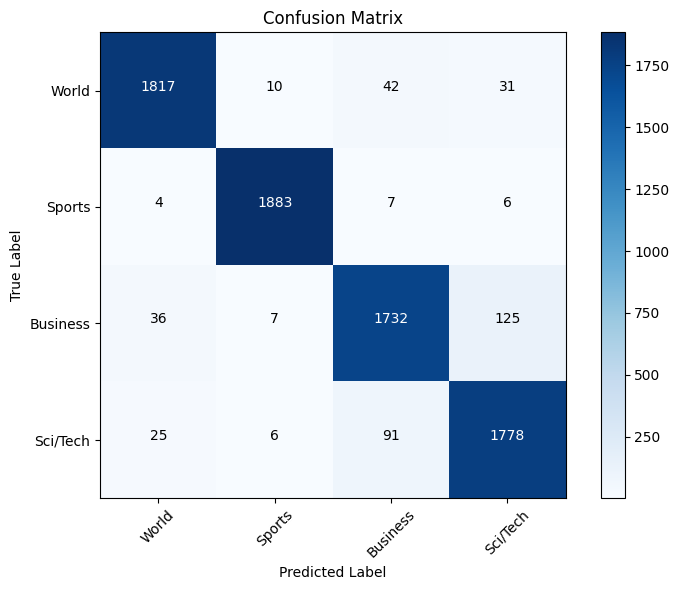

In [16]:
# Step 11: Detailed evaluation metrics
# Function to get predictions for the entire dataset
def get_predictions(model, dataloader):
    model.eval()

    predictions = []
    true_labels = []

    for batch in tqdm(dataloader, desc="Getting predictions"):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())

    return predictions, true_labels

# Get predictions
predictions, true_labels = get_predictions(model, test_dataloader)

# Calculate F1-score and other metrics
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")

# Detailed classification report
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [17]:
# Step 12: Save the model
# Create directory if it doesn't exist
import os
os.makedirs('./bert_ag_news', exist_ok=True)

# Save the model and tokenizer
model.save_pretrained('./bert_ag_news')
tokenizer.save_pretrained('./bert_ag_news')

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [18]:
# Step 13: Create a simple prediction function for demonstration
def predict_news_category(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()

    return predicted_class, confidence, predictions

# Test the prediction function
test_texts = [
    "Apple announces new iPhone with advanced AI features",
    "Manchester United wins championship after dramatic final",
    "Stock markets reach all-time high amid economic recovery",
    "International summit addresses climate change crisis"
]

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

for text in test_texts:
    pred_class, confidence, _ = predict_news_category(text)
    print(f"Text: {text}")
    print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.4f})")
    print()

Text: Apple announces new iPhone with advanced AI features
Predicted: Sci/Tech (confidence: 0.9790)

Text: Manchester United wins championship after dramatic final
Predicted: Sports (confidence: 0.6970)

Text: Stock markets reach all-time high amid economic recovery
Predicted: Business (confidence: 0.9613)

Text: International summit addresses climate change crisis
Predicted: Sci/Tech (confidence: 0.8775)



In [19]:
# Step 14: Create Streamlit deployment app
# Create a new file: app.py
%%writefile app.py
import streamlit as st
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Set page config
st.set_page_config(
    page_title="News Topic Classifier",
    page_icon="📰",
    layout="wide"
)

# Load model and tokenizer
@st.cache_resource
def load_model():
    try:
        tokenizer = BertTokenizer.from_pretrained('./bert_ag_news')
        model = BertForSequenceClassification.from_pretrained('./bert_ag_news')
        return tokenizer, model
    except:
        st.error("Model not found. Please run the training script first.")
        return None, None

# Class labels
class_labels = {
    0: "World News",
    1: "Sports",
    2: "Business",
    3: "Science & Technology"
}

# App title and description
st.title("📰 News Topic Classifier")
st.write("This app classifies news headlines into one of four categories using a fine-tuned BERT model.")

# Load model
tokenizer, model = load_model()

if tokenizer and model:
    # Input section
    st.header("Try It Out")
    news_text = st.text_area(
        "Enter a news headline:",
        "Apple announces new iPhone with advanced AI features",
        height=100
    )

    # Classify button
    if st.button("Classify"):
        if not news_text.strip():
            st.error("Please enter some text to classify.")
        else:
            with st.spinner("Analyzing..."):
                # Tokenize input
                inputs = tokenizer(
                    news_text,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=128
                )

                # Make prediction
                with torch.no_grad():
                    outputs = model(**inputs)
                    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
                    predicted_class = torch.argmax(predictions, dim=1).item()
                    confidence = predictions[0][predicted_class].item()

                # Display results
                st.subheader("Results")
                col1, col2 = st.columns(2)

                with col1:
                    st.metric("Predicted Category", class_labels[predicted_class])
                    st.metric("Confidence", f"{confidence:.2%}")

                with col2:
                    st.write("**Confidence Scores:**")
                    for i, label in class_labels.items():
                        score = predictions[0][i].item()
                        st.write(f"{label}: {score:.2%}")

                        # Progress bar for each category
                        st.progress(score)

# Model info section
st.header("About the Model")
st.write("""
This model is a fine-tuned version of BERT-base-uncased trained on the AG News dataset.
The AG News dataset contains news articles categorized into 4 classes:

- **World News**: International events, politics, conflicts
- **Sports**: Sports events, athletes, competitions
- **Business**: Companies, markets, economy
- **Science & Technology**: Scientific discoveries, technological advancements

The model achieves approximately 94% accuracy on the test set.
""")

# Footer
st.markdown("---")
st.markdown("Built with 🤍 using BERT, Transformers, and Streamlit")

Writing app.py


In [20]:
# Step 15: Create Gradio deployment app
# Create a new file: gradio_app.py
%%writefile gradio_app.py
import gradio as gr
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('./bert_ag_news')
model = BertForSequenceClassification.from_pretrained('./bert_ag_news')

# Class labels
class_labels = ["World News", "Sports", "Business", "Science & Technology"]

def classify_news(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()

    # Format results
    result = {
        class_labels[i]: float(predictions[0][i])
        for i in range(len(class_labels))
    }

    return result

# Create Gradio interface
iface = gr.Interface(
    fn=classify_news,
    inputs=gr.Textbox(lines=2, placeholder="Enter news headline here...", label="News Text"),
    outputs=gr.Label(num_top_classes=4, label="Predicted Category"),
    title="📰 News Topic Classifier",
    description="Classify news headlines into categories using a fine-tuned BERT model",
    examples=[
        ["Apple announces new iPhone with advanced AI features"],
        ["Manchester United wins championship after dramatic final"],
        ["Stock markets reach all-time high amid economic recovery"],
        ["International summit addresses climate change crisis"]
    ]
)

# Launch the interface
if __name__ == "__main__":
    iface.launch()

Writing gradio_app.py
